<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[23:13:03] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


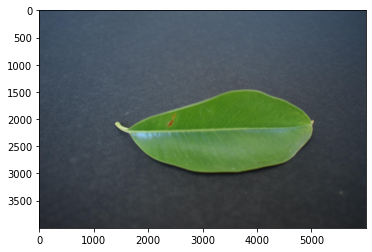

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

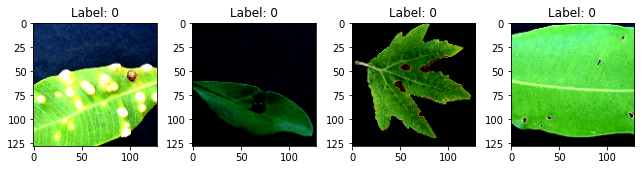

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[23:13:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[23:13:10] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[23:13:11] /work/mxnet/src/operator/cudnn_ops.cc:353: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.0818725898465982 samples/sec                   batch loss = 1.831458330154419 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2748622095873237 samples/sec                   batch loss = 0.3649333715438843 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2770432714722162 samples/sec                   batch loss = 1.1953368186950684 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2851927584299998 samples/sec                   batch loss = 0.35013318061828613 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.278375599242753 samples/sec                   batch loss = 0.5752069354057312 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.2778088354960169 samples/sec                   batch loss = 0.5614393353462219 | accuracy = 0.5416666666666666


Epoch[1] Batch[35] Speed: 1.2849928371590298 samples/sec                   batch loss = 1.0190390348434448 | accuracy = 0.5285714285714286


Epoch[1] Batch[40] Speed: 1.2695634315349988 samples/sec                   batch loss = 0.40118932723999023 | accuracy = 0.55


Epoch[1] Batch[45] Speed: 1.2698452681256214 samples/sec                   batch loss = 0.6617535948753357 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2786244290867195 samples/sec                   batch loss = 1.3719793558120728 | accuracy = 0.535


Epoch[1] Batch[55] Speed: 1.2820829740090578 samples/sec                   batch loss = 0.6073790192604065 | accuracy = 0.55


Epoch[1] Batch[60] Speed: 1.2767028509898373 samples/sec                   batch loss = 0.6023125052452087 | accuracy = 0.5333333333333333


Epoch[1] Batch[65] Speed: 1.2795846075054218 samples/sec                   batch loss = 0.5754942297935486 | accuracy = 0.5461538461538461


Epoch[1] Batch[70] Speed: 1.2796069566644646 samples/sec                   batch loss = 0.8157210350036621 | accuracy = 0.5642857142857143


Epoch[1] Batch[75] Speed: 1.283392267234676 samples/sec                   batch loss = 0.6043357849121094 | accuracy = 0.59


Epoch[1] Batch[80] Speed: 1.2821010995191706 samples/sec                   batch loss = 0.4203096926212311 | accuracy = 0.590625


Epoch[1] Batch[85] Speed: 1.2771921106064426 samples/sec                   batch loss = 0.8645666241645813 | accuracy = 0.5911764705882353


Epoch[1] Batch[90] Speed: 1.2781747743795728 samples/sec                   batch loss = 0.30830031633377075 | accuracy = 0.5972222222222222


Epoch[1] Batch[95] Speed: 1.2706539962905592 samples/sec                   batch loss = 0.7133526802062988 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.2763192088246482 samples/sec                   batch loss = 0.8621464371681213 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.2750357342840588 samples/sec                   batch loss = 0.2457423210144043 | accuracy = 0.6166666666666667


Epoch[1] Batch[110] Speed: 1.2745838549067123 samples/sec                   batch loss = 0.6446098685264587 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.280431883953778 samples/sec                   batch loss = 0.4338054955005646 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.278586815856833 samples/sec                   batch loss = 1.0511507987976074 | accuracy = 0.6166666666666667


Epoch[1] Batch[125] Speed: 1.2795147348215639 samples/sec                   batch loss = 0.5600870251655579 | accuracy = 0.618


Epoch[1] Batch[130] Speed: 1.2786795861664761 samples/sec                   batch loss = 0.6934996247291565 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.2853654633021279 samples/sec                   batch loss = 0.224666565656662 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2818285851199778 samples/sec                   batch loss = 0.878059446811676 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.278689039359214 samples/sec                   batch loss = 0.5056189894676208 | accuracy = 0.6344827586206897


Epoch[1] Batch[150] Speed: 1.2789225873405903 samples/sec                   batch loss = 0.3646504282951355 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.281488153929975 samples/sec                   batch loss = 0.8990464210510254 | accuracy = 0.6290322580645161


Epoch[1] Batch[160] Speed: 1.2894837143385716 samples/sec                   batch loss = 0.5653586387634277 | accuracy = 0.625


Epoch[1] Batch[165] Speed: 1.2857687532863242 samples/sec                   batch loss = 0.379582017660141 | accuracy = 0.6287878787878788


Epoch[1] Batch[170] Speed: 1.2786502529221015 samples/sec                   batch loss = 0.49384093284606934 | accuracy = 0.6308823529411764


Epoch[1] Batch[175] Speed: 1.2829367027200096 samples/sec                   batch loss = 0.4848845601081848 | accuracy = 0.63


Epoch[1] Batch[180] Speed: 1.2823132550747867 samples/sec                   batch loss = 0.6134858131408691 | accuracy = 0.6305555555555555


Epoch[1] Batch[185] Speed: 1.280924006384305 samples/sec                   batch loss = 0.3636600971221924 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.2801544131566773 samples/sec                   batch loss = 0.8062373399734497 | accuracy = 0.6381578947368421


Epoch[1] Batch[195] Speed: 1.280370712803275 samples/sec                   batch loss = 0.5099725723266602 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.2748977632849978 samples/sec                   batch loss = 0.4996308386325836 | accuracy = 0.64875


Epoch[1] Batch[205] Speed: 1.2794603838346987 samples/sec                   batch loss = 0.9026039838790894 | accuracy = 0.6463414634146342


Epoch[1] Batch[210] Speed: 1.2769342160914474 samples/sec                   batch loss = 0.5732214450836182 | accuracy = 0.65


Epoch[1] Batch[215] Speed: 1.2752004859639303 samples/sec                   batch loss = 1.9854587316513062 | accuracy = 0.65


Epoch[1] Batch[220] Speed: 1.2721253083027306 samples/sec                   batch loss = 0.5822468400001526 | accuracy = 0.65


Epoch[1] Batch[225] Speed: 1.2761069935421923 samples/sec                   batch loss = 0.7344375848770142 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.2748067032830428 samples/sec                   batch loss = 1.2292038202285767 | accuracy = 0.6478260869565218


Epoch[1] Batch[235] Speed: 1.2752756074773957 samples/sec                   batch loss = 0.7947759628295898 | accuracy = 0.65


Epoch[1] Batch[240] Speed: 1.2825599925632813 samples/sec                   batch loss = 0.2817493677139282 | accuracy = 0.6510416666666666


Epoch[1] Batch[245] Speed: 1.2710638023842082 samples/sec                   batch loss = 0.9975630044937134 | accuracy = 0.65


Epoch[1] Batch[250] Speed: 1.2811026091410613 samples/sec                   batch loss = 0.7022970914840698 | accuracy = 0.652


Epoch[1] Batch[255] Speed: 1.2818471931292592 samples/sec                   batch loss = 0.8769481182098389 | accuracy = 0.6509803921568628


Epoch[1] Batch[260] Speed: 1.283136377201292 samples/sec                   batch loss = 0.4982341527938843 | accuracy = 0.6461538461538462


Epoch[1] Batch[265] Speed: 1.2826442206945332 samples/sec                   batch loss = 0.6256118416786194 | accuracy = 0.6433962264150943


Epoch[1] Batch[270] Speed: 1.2786667222524244 samples/sec                   batch loss = 0.709270715713501 | accuracy = 0.6388888888888888


Epoch[1] Batch[275] Speed: 1.2760988402915587 samples/sec                   batch loss = 0.37200823426246643 | accuracy = 0.6418181818181818


Epoch[1] Batch[280] Speed: 1.2829468076011383 samples/sec                   batch loss = 0.8831986784934998 | accuracy = 0.6392857142857142


Epoch[1] Batch[285] Speed: 1.276554708647278 samples/sec                   batch loss = 0.6901307106018066 | accuracy = 0.637719298245614


Epoch[1] Batch[290] Speed: 1.283415927738578 samples/sec                   batch loss = 0.6426075100898743 | accuracy = 0.6396551724137931


Epoch[1] Batch[295] Speed: 1.2822039837458645 samples/sec                   batch loss = 0.7229207754135132 | accuracy = 0.6406779661016949


Epoch[1] Batch[300] Speed: 1.2736166611237183 samples/sec                   batch loss = 0.9696347117424011 | accuracy = 0.6433333333333333


Epoch[1] Batch[305] Speed: 1.2686118010153906 samples/sec                   batch loss = 0.4042564034461975 | accuracy = 0.6418032786885246


Epoch[1] Batch[310] Speed: 1.2712216535124916 samples/sec                   batch loss = 0.38108834624290466 | accuracy = 0.6451612903225806


Epoch[1] Batch[315] Speed: 1.2825239121849745 samples/sec                   batch loss = 0.2946477234363556 | accuracy = 0.6476190476190476


Epoch[1] Batch[320] Speed: 1.273860933412106 samples/sec                   batch loss = 1.4597111940383911 | accuracy = 0.646875


Epoch[1] Batch[325] Speed: 1.272379816373771 samples/sec                   batch loss = 1.1057775020599365 | accuracy = 0.6507692307692308


Epoch[1] Batch[330] Speed: 1.2778151614697495 samples/sec                   batch loss = 0.4774874746799469 | accuracy = 0.6515151515151515


Epoch[1] Batch[335] Speed: 1.2714123984491652 samples/sec                   batch loss = 0.3357640504837036 | accuracy = 0.6529850746268657


Epoch[1] Batch[340] Speed: 1.2703370760483477 samples/sec                   batch loss = 1.1205741167068481 | accuracy = 0.6507352941176471


Epoch[1] Batch[345] Speed: 1.2711255320501422 samples/sec                   batch loss = 0.8756765723228455 | accuracy = 0.65


Epoch[1] Batch[350] Speed: 1.2781649392831855 samples/sec                   batch loss = 0.6313906311988831 | accuracy = 0.6492857142857142


Epoch[1] Batch[355] Speed: 1.2795629422536874 samples/sec                   batch loss = 0.6775316596031189 | accuracy = 0.65


Epoch[1] Batch[360] Speed: 1.27982765992586 samples/sec                   batch loss = 0.4258664548397064 | accuracy = 0.6506944444444445


Epoch[1] Batch[365] Speed: 1.284214023219197 samples/sec                   batch loss = 0.5053092241287231 | accuracy = 0.6534246575342466


Epoch[1] Batch[370] Speed: 1.2740415385199528 samples/sec                   batch loss = 0.6384862661361694 | accuracy = 0.654054054054054


Epoch[1] Batch[375] Speed: 1.279478630419535 samples/sec                   batch loss = 0.5198529958724976 | accuracy = 0.6553333333333333


Epoch[1] Batch[380] Speed: 1.277687194338008 samples/sec                   batch loss = 0.9288400411605835 | accuracy = 0.6539473684210526


Epoch[1] Batch[385] Speed: 1.2746882478781998 samples/sec                   batch loss = 0.5251179933547974 | accuracy = 0.6551948051948052


Epoch[1] Batch[390] Speed: 1.2846660688430336 samples/sec                   batch loss = 0.45108762383461 | accuracy = 0.6557692307692308


Epoch[1] Batch[395] Speed: 1.2889295384782038 samples/sec                   batch loss = 0.15529806911945343 | accuracy = 0.6575949367088607


Epoch[1] Batch[400] Speed: 1.2800303718143946 samples/sec                   batch loss = 0.4617990553379059 | accuracy = 0.65625


Epoch[1] Batch[405] Speed: 1.275849634041119 samples/sec                   batch loss = 0.29717817902565 | accuracy = 0.6561728395061729


Epoch[1] Batch[410] Speed: 1.2765779234376597 samples/sec                   batch loss = 0.520566463470459 | accuracy = 0.6560975609756098


Epoch[1] Batch[415] Speed: 1.2728012616630853 samples/sec                   batch loss = 0.33894118666648865 | accuracy = 0.6572289156626506


Epoch[1] Batch[420] Speed: 1.2778054292284118 samples/sec                   batch loss = 0.6082041263580322 | accuracy = 0.655952380952381


Epoch[1] Batch[425] Speed: 1.2828159469930178 samples/sec                   batch loss = 0.6733117699623108 | accuracy = 0.6570588235294118


Epoch[1] Batch[430] Speed: 1.2791315466588045 samples/sec                   batch loss = 0.38572654128074646 | accuracy = 0.6593023255813953


Epoch[1] Batch[435] Speed: 1.2770056540092225 samples/sec                   batch loss = 1.0497440099716187 | accuracy = 0.6586206896551724


Epoch[1] Batch[440] Speed: 1.2780926900468965 samples/sec                   batch loss = 0.30228444933891296 | accuracy = 0.6602272727272728


Epoch[1] Batch[445] Speed: 1.274204388197998 samples/sec                   batch loss = 0.4972451627254486 | accuracy = 0.6612359550561798


Epoch[1] Batch[450] Speed: 1.2831189093362008 samples/sec                   batch loss = 0.4420459568500519 | accuracy = 0.6605555555555556


Epoch[1] Batch[455] Speed: 1.2856392867671282 samples/sec                   batch loss = 1.2242059707641602 | accuracy = 0.6615384615384615


Epoch[1] Batch[460] Speed: 1.2760734105838267 samples/sec                   batch loss = 1.137475609779358 | accuracy = 0.6603260869565217


Epoch[1] Batch[465] Speed: 1.2784641497419862 samples/sec                   batch loss = 1.036373496055603 | accuracy = 0.6596774193548387


Epoch[1] Batch[470] Speed: 1.2767598828138704 samples/sec                   batch loss = 0.5634286403656006 | accuracy = 0.6617021276595745


Epoch[1] Batch[475] Speed: 1.282174194614372 samples/sec                   batch loss = 0.309222012758255 | accuracy = 0.661578947368421


Epoch[1] Batch[480] Speed: 1.2801274540960386 samples/sec                   batch loss = 1.2496042251586914 | accuracy = 0.6609375


Epoch[1] Batch[485] Speed: 1.2764460280344323 samples/sec                   batch loss = 0.6655735373497009 | accuracy = 0.6603092783505154


Epoch[1] Batch[490] Speed: 1.2783559230198407 samples/sec                   batch loss = 0.8611379265785217 | accuracy = 0.6612244897959184


Epoch[1] Batch[495] Speed: 1.282224856560727 samples/sec                   batch loss = 0.39367493987083435 | accuracy = 0.6606060606060606


Epoch[1] Batch[500] Speed: 1.279742532267945 samples/sec                   batch loss = 0.49865978956222534 | accuracy = 0.662


Epoch[1] Batch[505] Speed: 1.2805971534577891 samples/sec                   batch loss = 0.5499261617660522 | accuracy = 0.6618811881188119


Epoch[1] Batch[510] Speed: 1.2815544244567882 samples/sec                   batch loss = 0.5085593461990356 | accuracy = 0.6612745098039216


Epoch[1] Batch[515] Speed: 1.282112954859766 samples/sec                   batch loss = 0.7707958221435547 | accuracy = 0.6601941747572816


Epoch[1] Batch[520] Speed: 1.2806942239731849 samples/sec                   batch loss = 0.2650274336338043 | accuracy = 0.6610576923076923


Epoch[1] Batch[525] Speed: 1.2782519997525357 samples/sec                   batch loss = 0.5142476558685303 | accuracy = 0.6619047619047619


Epoch[1] Batch[530] Speed: 1.28381809334539 samples/sec                   batch loss = 1.1418845653533936 | accuracy = 0.6617924528301887


Epoch[1] Batch[535] Speed: 1.2764351512796217 samples/sec                   batch loss = 0.5940269231796265 | accuracy = 0.6621495327102803


Epoch[1] Batch[540] Speed: 1.2790856146080873 samples/sec                   batch loss = 0.47079998254776 | accuracy = 0.662962962962963


Epoch[1] Batch[545] Speed: 1.2760366266549872 samples/sec                   batch loss = 0.528291642665863 | accuracy = 0.6633027522935779


Epoch[1] Batch[550] Speed: 1.2786583413567596 samples/sec                   batch loss = 0.8314215540885925 | accuracy = 0.6631818181818182


Epoch[1] Batch[555] Speed: 1.2815149745583176 samples/sec                   batch loss = 0.6324578523635864 | accuracy = 0.6617117117117117


Epoch[1] Batch[560] Speed: 1.2792478055696468 samples/sec                   batch loss = 0.34071001410484314 | accuracy = 0.6625


Epoch[1] Batch[565] Speed: 1.2808975038662345 samples/sec                   batch loss = 0.41720232367515564 | accuracy = 0.6623893805309734


Epoch[1] Batch[570] Speed: 1.2791129198881697 samples/sec                   batch loss = 0.3761085867881775 | accuracy = 0.6635964912280702


Epoch[1] Batch[575] Speed: 1.280540560220314 samples/sec                   batch loss = 0.3227258324623108 | accuracy = 0.6660869565217391


Epoch[1] Batch[580] Speed: 1.2826118616637932 samples/sec                   batch loss = 0.3824058771133423 | accuracy = 0.6663793103448276


Epoch[1] Batch[585] Speed: 1.2759432690543135 samples/sec                   batch loss = 0.4231763482093811 | accuracy = 0.6666666666666666


Epoch[1] Batch[590] Speed: 1.2733776048422487 samples/sec                   batch loss = 1.731787919998169 | accuracy = 0.6669491525423729


Epoch[1] Batch[595] Speed: 1.2779911459670745 samples/sec                   batch loss = 0.2719959616661072 | accuracy = 0.6676470588235294


Epoch[1] Batch[600] Speed: 1.272024999514761 samples/sec                   batch loss = 0.16950085759162903 | accuracy = 0.6679166666666667


Epoch[1] Batch[605] Speed: 1.2782044753417974 samples/sec                   batch loss = 0.7986265420913696 | accuracy = 0.6673553719008265


Epoch[1] Batch[610] Speed: 1.2790589930824057 samples/sec                   batch loss = 0.9894759058952332 | accuracy = 0.6668032786885246


Epoch[1] Batch[615] Speed: 1.2792152275356587 samples/sec                   batch loss = 0.5425920486450195 | accuracy = 0.6658536585365854


Epoch[1] Batch[620] Speed: 1.2798799917213572 samples/sec                   batch loss = 1.1395519971847534 | accuracy = 0.6665322580645161


Epoch[1] Batch[625] Speed: 1.2796002225562007 samples/sec                   batch loss = 0.641839861869812 | accuracy = 0.6668


Epoch[1] Batch[630] Speed: 1.277987154631027 samples/sec                   batch loss = 0.3323022723197937 | accuracy = 0.6678571428571428


Epoch[1] Batch[635] Speed: 1.279907721496825 samples/sec                   batch loss = 0.6422861814498901 | accuracy = 0.6677165354330709


Epoch[1] Batch[640] Speed: 1.278057834171979 samples/sec                   batch loss = 0.5866958498954773 | accuracy = 0.66796875


Epoch[1] Batch[645] Speed: 1.279510343636804 samples/sec                   batch loss = 0.44513940811157227 | accuracy = 0.6682170542635659


Epoch[1] Batch[650] Speed: 1.2816598645172257 samples/sec                   batch loss = 0.4174422025680542 | accuracy = 0.6703846153846154


Epoch[1] Batch[655] Speed: 1.2814044690400872 samples/sec                   batch loss = 0.3312172591686249 | accuracy = 0.6721374045801527


Epoch[1] Batch[660] Speed: 1.2766206641720494 samples/sec                   batch loss = 0.179144024848938 | accuracy = 0.6731060606060606


Epoch[1] Batch[665] Speed: 1.285228299938409 samples/sec                   batch loss = 0.3024044930934906 | accuracy = 0.6740601503759398


Epoch[1] Batch[670] Speed: 1.2800754927334506 samples/sec                   batch loss = 0.31069520115852356 | accuracy = 0.6742537313432836


Epoch[1] Batch[675] Speed: 1.2758008328453232 samples/sec                   batch loss = 0.4242182672023773 | accuracy = 0.6751851851851852


Epoch[1] Batch[680] Speed: 1.278470579628862 samples/sec                   batch loss = 0.13510321080684662 | accuracy = 0.6757352941176471


Epoch[1] Batch[685] Speed: 1.2816958962958878 samples/sec                   batch loss = 0.711805522441864 | accuracy = 0.6751824817518248


Epoch[1] Batch[690] Speed: 1.2820553458390898 samples/sec                   batch loss = 0.8806807398796082 | accuracy = 0.6753623188405797


Epoch[1] Batch[695] Speed: 1.2839590828163991 samples/sec                   batch loss = 0.12652088701725006 | accuracy = 0.6751798561151079


Epoch[1] Batch[700] Speed: 1.2828771558283028 samples/sec                   batch loss = 0.2890379726886749 | accuracy = 0.675


Epoch[1] Batch[705] Speed: 1.283774378161379 samples/sec                   batch loss = 0.49678122997283936 | accuracy = 0.676241134751773


Epoch[1] Batch[710] Speed: 1.2801186633435029 samples/sec                   batch loss = 0.23648762702941895 | accuracy = 0.6767605633802817


Epoch[1] Batch[715] Speed: 1.2801981752088545 samples/sec                   batch loss = 0.7147274613380432 | accuracy = 0.6755244755244755


Epoch[1] Batch[720] Speed: 1.2782024303132657 samples/sec                   batch loss = 0.39026087522506714 | accuracy = 0.6756944444444445


Epoch[1] Batch[725] Speed: 1.28425226318129 samples/sec                   batch loss = 0.5772057771682739 | accuracy = 0.6765517241379311


Epoch[1] Batch[730] Speed: 1.2789242447053621 samples/sec                   batch loss = 1.2104912996292114 | accuracy = 0.6753424657534246


Epoch[1] Batch[735] Speed: 1.2771574010573543 samples/sec                   batch loss = 0.3865821063518524 | accuracy = 0.6751700680272109


Epoch[1] Batch[740] Speed: 1.2753706125158943 samples/sec                   batch loss = 0.7939208149909973 | accuracy = 0.675


Epoch[1] Batch[745] Speed: 1.2785852568069862 samples/sec                   batch loss = 0.40337565541267395 | accuracy = 0.675503355704698


Epoch[1] Batch[750] Speed: 1.283718289555586 samples/sec                   batch loss = 0.3828273117542267 | accuracy = 0.676


Epoch[1] Batch[755] Speed: 1.2772320726757542 samples/sec                   batch loss = 0.634950578212738 | accuracy = 0.676158940397351


Epoch[1] Batch[760] Speed: 1.281180482229911 samples/sec                   batch loss = 0.3480216860771179 | accuracy = 0.6769736842105263


Epoch[1] Batch[765] Speed: 1.2837498203752813 samples/sec                   batch loss = 0.4599684178829193 | accuracy = 0.6777777777777778


Epoch[1] Batch[770] Speed: 1.2777564783026385 samples/sec                   batch loss = 0.5295670032501221 | accuracy = 0.6785714285714286


Epoch[1] Batch[775] Speed: 1.2771916244652777 samples/sec                   batch loss = 0.4699791967868805 | accuracy = 0.6790322580645162


Epoch[1] Batch[780] Speed: 1.2775345431313698 samples/sec                   batch loss = 0.5544798374176025 | accuracy = 0.6791666666666667


Epoch[1] Batch[785] Speed: 1.2777743843692664 samples/sec                   batch loss = 0.8147581815719604 | accuracy = 0.6799363057324841


[Epoch 1] training: accuracy=0.6808375634517766
[Epoch 1] time cost: 642.0402278900146
[Epoch 1] validation: validation accuracy=0.7477777777777778


Epoch[2] Batch[5] Speed: 1.2728465503358923 samples/sec                   batch loss = 0.4901142418384552 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2804436107205415 samples/sec                   batch loss = 0.1656341850757599 | accuracy = 0.85


Epoch[2] Batch[15] Speed: 1.2784933770216769 samples/sec                   batch loss = 0.4058048725128174 | accuracy = 0.8666666666666667


Epoch[2] Batch[20] Speed: 1.2794716049348822 samples/sec                   batch loss = 0.49194765090942383 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2807454534198104 samples/sec                   batch loss = 0.6100667715072632 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.2831431485802816 samples/sec                   batch loss = 0.14286917448043823 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.2804566081380033 samples/sec                   batch loss = 0.33590951561927795 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.282436955050617 samples/sec                   batch loss = 0.3745485842227936 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2763186262524338 samples/sec                   batch loss = 0.24317438900470734 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.284241449593464 samples/sec                   batch loss = 0.40667781233787537 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2838826400823657 samples/sec                   batch loss = 0.44989144802093506 | accuracy = 0.7545454545454545


Epoch[2] Batch[60] Speed: 1.2781563702136796 samples/sec                   batch loss = 0.7468166947364807 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2761407724047409 samples/sec                   batch loss = 0.7278029918670654 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.2779175536325045 samples/sec                   batch loss = 0.7230876684188843 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2788064850058687 samples/sec                   batch loss = 0.6783961057662964 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.280886551116312 samples/sec                   batch loss = 0.7693459987640381 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2778224607480417 samples/sec                   batch loss = 0.7689088582992554 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2797380419031963 samples/sec                   batch loss = 0.5473681092262268 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.2785095500240808 samples/sec                   batch loss = 0.32807037234306335 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2743031052354825 samples/sec                   batch loss = 0.19135665893554688 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.2775386289218016 samples/sec                   batch loss = 0.47474205493927 | accuracy = 0.7547619047619047


Epoch[2] Batch[110] Speed: 1.2744363006926016 samples/sec                   batch loss = 0.7057767510414124 | accuracy = 0.759090909090909


Epoch[2] Batch[115] Speed: 1.2807640299950052 samples/sec                   batch loss = 0.5467225313186646 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2795843147268595 samples/sec                   batch loss = 0.6992226243019104 | accuracy = 0.75625


Epoch[2] Batch[125] Speed: 1.2781491644941636 samples/sec                   batch loss = 0.348330020904541 | accuracy = 0.758


Epoch[2] Batch[130] Speed: 1.2735693840807167 samples/sec                   batch loss = 0.7364395260810852 | accuracy = 0.7519230769230769


Epoch[2] Batch[135] Speed: 1.2786360253214992 samples/sec                   batch loss = 0.23058971762657166 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.279607639838828 samples/sec                   batch loss = 0.6945450901985168 | accuracy = 0.7517857142857143


Epoch[2] Batch[145] Speed: 1.2766099787201437 samples/sec                   batch loss = 0.32902228832244873 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.278071464734686 samples/sec                   batch loss = 0.6077246069908142 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2817595443329761 samples/sec                   batch loss = 0.4122834801673889 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2731961250774442 samples/sec                   batch loss = 0.48121699690818787 | accuracy = 0.74375


Epoch[2] Batch[165] Speed: 1.2789581728811759 samples/sec                   batch loss = 0.37453722953796387 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2763280445684333 samples/sec                   batch loss = 0.4149857759475708 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.276408834184401 samples/sec                   batch loss = 0.5338951945304871 | accuracy = 0.7385714285714285


Epoch[2] Batch[180] Speed: 1.2768211952786002 samples/sec                   batch loss = 0.23871354758739471 | accuracy = 0.7416666666666667


Epoch[2] Batch[185] Speed: 1.2767013936846063 samples/sec                   batch loss = 0.6838101148605347 | accuracy = 0.7418918918918919


Epoch[2] Batch[190] Speed: 1.2766443670856602 samples/sec                   batch loss = 0.510555624961853 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.2774435924202587 samples/sec                   batch loss = 0.43840622901916504 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.2728475160143278 samples/sec                   batch loss = 0.8199290633201599 | accuracy = 0.73625


Epoch[2] Batch[205] Speed: 1.276417962500408 samples/sec                   batch loss = 0.2782362401485443 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.2740439572539721 samples/sec                   batch loss = 0.7262023687362671 | accuracy = 0.7440476190476191


Epoch[2] Batch[215] Speed: 1.2749609316936146 samples/sec                   batch loss = 0.2983776032924652 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.278494253860714 samples/sec                   batch loss = 0.5169813632965088 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2776185016454924 samples/sec                   batch loss = 0.3239728510379791 | accuracy = 0.7466666666666667


Epoch[2] Batch[230] Speed: 1.2785803848007198 samples/sec                   batch loss = 0.27466005086898804 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.275646013207028 samples/sec                   batch loss = 0.7462619543075562 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2869895219521057 samples/sec                   batch loss = 0.2773076593875885 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.2819905908588531 samples/sec                   batch loss = 0.4469251036643982 | accuracy = 0.7448979591836735


Epoch[2] Batch[250] Speed: 1.2762368772254176 samples/sec                   batch loss = 0.2969993054866791 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.2805317637932072 samples/sec                   batch loss = 0.3285102844238281 | accuracy = 0.746078431372549


Epoch[2] Batch[260] Speed: 1.2782302822165388 samples/sec                   batch loss = 0.5241226553916931 | accuracy = 0.7471153846153846


Epoch[2] Batch[265] Speed: 1.2788236406985547 samples/sec                   batch loss = 0.6637746691703796 | accuracy = 0.7490566037735849


Epoch[2] Batch[270] Speed: 1.2743064928562433 samples/sec                   batch loss = 0.22245748341083527 | accuracy = 0.7509259259259259


Epoch[2] Batch[275] Speed: 1.2776719178456186 samples/sec                   batch loss = 0.5084155797958374 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2795694807884006 samples/sec                   batch loss = 0.4645753502845764 | accuracy = 0.7508928571428571


Epoch[2] Batch[285] Speed: 1.2715640718842438 samples/sec                   batch loss = 1.3222137689590454 | accuracy = 0.7491228070175439


Epoch[2] Batch[290] Speed: 1.2716474402294742 samples/sec                   batch loss = 0.28097274899482727 | accuracy = 0.7517241379310344


Epoch[2] Batch[295] Speed: 1.2904602777257517 samples/sec                   batch loss = 1.0366331338882446 | accuracy = 0.7516949152542373


Epoch[2] Batch[300] Speed: 1.2987758283876056 samples/sec                   batch loss = 0.45437803864479065 | accuracy = 0.7525


Epoch[2] Batch[305] Speed: 1.2987808555183928 samples/sec                   batch loss = 0.2008213996887207 | accuracy = 0.7524590163934426


Epoch[2] Batch[310] Speed: 1.2978564177891223 samples/sec                   batch loss = 0.4809798002243042 | accuracy = 0.7548387096774194


Epoch[2] Batch[315] Speed: 1.2952302603644108 samples/sec                   batch loss = 0.3848661482334137 | accuracy = 0.7515873015873016


Epoch[2] Batch[320] Speed: 1.3011089723093112 samples/sec                   batch loss = 0.5191665291786194 | accuracy = 0.7515625


Epoch[2] Batch[325] Speed: 1.3020088487656685 samples/sec                   batch loss = 0.4984128177165985 | accuracy = 0.7492307692307693


Epoch[2] Batch[330] Speed: 1.3079970158997904 samples/sec                   batch loss = 0.6653863787651062 | accuracy = 0.7515151515151515


Epoch[2] Batch[335] Speed: 1.3008084493697631 samples/sec                   batch loss = 0.4397798478603363 | accuracy = 0.7514925373134328


Epoch[2] Batch[340] Speed: 1.311823674152105 samples/sec                   batch loss = 0.627554178237915 | accuracy = 0.7514705882352941


Epoch[2] Batch[345] Speed: 1.307088133082717 samples/sec                   batch loss = 0.3784940838813782 | accuracy = 0.7528985507246376


Epoch[2] Batch[350] Speed: 1.304858534685364 samples/sec                   batch loss = 0.35894137620925903 | accuracy = 0.7528571428571429


Epoch[2] Batch[355] Speed: 1.3044830423664233 samples/sec                   batch loss = 1.2104544639587402 | accuracy = 0.7514084507042254


Epoch[2] Batch[360] Speed: 1.3029035963155413 samples/sec                   batch loss = 0.22481048107147217 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.3140561627438034 samples/sec                   batch loss = 0.5639938712120056 | accuracy = 0.7520547945205479


Epoch[2] Batch[370] Speed: 1.304684306157102 samples/sec                   batch loss = 0.39255595207214355 | accuracy = 0.754054054054054


Epoch[2] Batch[375] Speed: 1.2988649149106177 samples/sec                   batch loss = 0.13366377353668213 | accuracy = 0.754


Epoch[2] Batch[380] Speed: 1.3040367099834667 samples/sec                   batch loss = 0.22510027885437012 | accuracy = 0.7546052631578948


Epoch[2] Batch[385] Speed: 1.2990265285412825 samples/sec                   batch loss = 0.299543172121048 | accuracy = 0.7564935064935064


Epoch[2] Batch[390] Speed: 1.3027790527752672 samples/sec                   batch loss = 0.7782067060470581 | accuracy = 0.7551282051282051


Epoch[2] Batch[395] Speed: 1.30738657279767 samples/sec                   batch loss = 0.08275806903839111 | accuracy = 0.7550632911392405


Epoch[2] Batch[400] Speed: 1.309944062821538 samples/sec                   batch loss = 0.3618190288543701 | accuracy = 0.755


Epoch[2] Batch[405] Speed: 1.3073745510901245 samples/sec                   batch loss = 0.6101250052452087 | accuracy = 0.754320987654321


Epoch[2] Batch[410] Speed: 1.3038269318511486 samples/sec                   batch loss = 0.31417232751846313 | accuracy = 0.7542682926829268


Epoch[2] Batch[415] Speed: 1.309416005794854 samples/sec                   batch loss = 0.21598024666309357 | accuracy = 0.7560240963855421


Epoch[2] Batch[420] Speed: 1.3033390281661168 samples/sec                   batch loss = 0.4768886864185333 | accuracy = 0.7559523809523809


Epoch[2] Batch[425] Speed: 1.3061995291607218 samples/sec                   batch loss = 0.4660036861896515 | accuracy = 0.7570588235294118


Epoch[2] Batch[430] Speed: 1.3075999439462496 samples/sec                   batch loss = 0.39912983775138855 | accuracy = 0.7563953488372093


Epoch[2] Batch[435] Speed: 1.3042052907904251 samples/sec                   batch loss = 0.4864850342273712 | accuracy = 0.7563218390804598


Epoch[2] Batch[440] Speed: 1.3032180456828089 samples/sec                   batch loss = 0.6124516725540161 | accuracy = 0.7568181818181818


Epoch[2] Batch[445] Speed: 1.3105595588415075 samples/sec                   batch loss = 0.34694862365722656 | accuracy = 0.7567415730337078


Epoch[2] Batch[450] Speed: 1.302119601758479 samples/sec                   batch loss = 0.26812490820884705 | accuracy = 0.7583333333333333


Epoch[2] Batch[455] Speed: 1.3052123099610993 samples/sec                   batch loss = 0.3233143091201782 | accuracy = 0.7598901098901099


Epoch[2] Batch[460] Speed: 1.2859233787471955 samples/sec                   batch loss = 0.665103554725647 | accuracy = 0.7608695652173914


Epoch[2] Batch[465] Speed: 1.278886223888726 samples/sec                   batch loss = 0.37302371859550476 | accuracy = 0.7612903225806451


Epoch[2] Batch[470] Speed: 1.2806360581007565 samples/sec                   batch loss = 0.24190478026866913 | accuracy = 0.7617021276595745


Epoch[2] Batch[475] Speed: 1.276131550986074 samples/sec                   batch loss = 0.5790139436721802 | accuracy = 0.761578947368421


Epoch[2] Batch[480] Speed: 1.2858743952110936 samples/sec                   batch loss = 0.2266962081193924 | accuracy = 0.7619791666666667


Epoch[2] Batch[485] Speed: 1.276796514117183 samples/sec                   batch loss = 0.5004906058311462 | accuracy = 0.7623711340206185


Epoch[2] Batch[490] Speed: 1.2775328893664821 samples/sec                   batch loss = 0.14075350761413574 | accuracy = 0.7627551020408163


Epoch[2] Batch[495] Speed: 1.2781197582109205 samples/sec                   batch loss = 0.8287489414215088 | accuracy = 0.7626262626262627


Epoch[2] Batch[500] Speed: 1.2727468036464558 samples/sec                   batch loss = 0.13119934499263763 | accuracy = 0.764


Epoch[2] Batch[505] Speed: 1.279806279322954 samples/sec                   batch loss = 0.7967751026153564 | accuracy = 0.7638613861386139


Epoch[2] Batch[510] Speed: 1.280917356202902 samples/sec                   batch loss = 0.1358940452337265 | accuracy = 0.765686274509804


Epoch[2] Batch[515] Speed: 1.2757257464481149 samples/sec                   batch loss = 0.7866593599319458 | accuracy = 0.7655339805825243


Epoch[2] Batch[520] Speed: 1.2802313894776667 samples/sec                   batch loss = 0.2594747841358185 | accuracy = 0.7668269230769231


Epoch[2] Batch[525] Speed: 1.2747635027682458 samples/sec                   batch loss = 1.1488744020462036 | accuracy = 0.7657142857142857


Epoch[2] Batch[530] Speed: 1.2756966455700773 samples/sec                   batch loss = 0.12530329823493958 | accuracy = 0.7674528301886793


Epoch[2] Batch[535] Speed: 1.2795658699475358 samples/sec                   batch loss = 0.46570247411727905 | accuracy = 0.7677570093457944


Epoch[2] Batch[540] Speed: 1.2762307610328414 samples/sec                   batch loss = 0.4103719890117645 | accuracy = 0.7675925925925926


Epoch[2] Batch[545] Speed: 1.2794440891961691 samples/sec                   batch loss = 1.74077308177948 | accuracy = 0.7669724770642202


Epoch[2] Batch[550] Speed: 1.2812365449748178 samples/sec                   batch loss = 0.5500487089157104 | accuracy = 0.7663636363636364


Epoch[2] Batch[555] Speed: 1.2797312087999095 samples/sec                   batch loss = 0.9248206615447998 | accuracy = 0.7666666666666667


Epoch[2] Batch[560] Speed: 1.281728111204621 samples/sec                   batch loss = 0.3091735243797302 | accuracy = 0.7674107142857143


Epoch[2] Batch[565] Speed: 1.277984234157031 samples/sec                   batch loss = 0.31923800706863403 | accuracy = 0.768141592920354


Epoch[2] Batch[570] Speed: 1.2763602815062058 samples/sec                   batch loss = 0.692945122718811 | accuracy = 0.7679824561403509


Epoch[2] Batch[575] Speed: 1.2769487946091946 samples/sec                   batch loss = 0.3178167939186096 | accuracy = 0.7682608695652174


Epoch[2] Batch[580] Speed: 1.2724270051388644 samples/sec                   batch loss = 0.5314205288887024 | accuracy = 0.7689655172413793


Epoch[2] Batch[585] Speed: 1.2790012681595144 samples/sec                   batch loss = 0.6261909604072571 | accuracy = 0.7688034188034188


Epoch[2] Batch[590] Speed: 1.2768910656297727 samples/sec                   batch loss = 0.7845544815063477 | accuracy = 0.7686440677966102


Epoch[2] Batch[595] Speed: 1.277298487193148 samples/sec                   batch loss = 0.26580530405044556 | accuracy = 0.769327731092437


Epoch[2] Batch[600] Speed: 1.2768010810317991 samples/sec                   batch loss = 0.5469446778297424 | accuracy = 0.7691666666666667


Epoch[2] Batch[605] Speed: 1.2757695942782505 samples/sec                   batch loss = 0.3792714476585388 | accuracy = 0.7702479338842976


Epoch[2] Batch[610] Speed: 1.2854996025246865 samples/sec                   batch loss = 0.35165196657180786 | accuracy = 0.7700819672131147


Epoch[2] Batch[615] Speed: 1.2786729592693373 samples/sec                   batch loss = 0.17273767292499542 | accuracy = 0.7699186991869919


Epoch[2] Batch[620] Speed: 1.275376041802787 samples/sec                   batch loss = 0.4687923789024353 | accuracy = 0.7701612903225806


Epoch[2] Batch[625] Speed: 1.2757320518133533 samples/sec                   batch loss = 0.593404233455658 | accuracy = 0.7704


Epoch[2] Batch[630] Speed: 1.272240875920158 samples/sec                   batch loss = 0.2595551609992981 | accuracy = 0.7698412698412699


Epoch[2] Batch[635] Speed: 1.277162553896373 samples/sec                   batch loss = 0.579556405544281 | accuracy = 0.7677165354330708


Epoch[2] Batch[640] Speed: 1.2805221855989095 samples/sec                   batch loss = 0.40836232900619507 | accuracy = 0.76875


Epoch[2] Batch[645] Speed: 1.278448659825552 samples/sec                   batch loss = 0.23099558055400848 | accuracy = 0.7670542635658915


Epoch[2] Batch[650] Speed: 1.2857528887875238 samples/sec                   batch loss = 0.5077699422836304 | accuracy = 0.7661538461538462


Epoch[2] Batch[655] Speed: 1.2835413135162879 samples/sec                   batch loss = 0.3858487606048584 | accuracy = 0.767557251908397


Epoch[2] Batch[660] Speed: 1.277253659067269 samples/sec                   batch loss = 0.3251924216747284 | accuracy = 0.7681818181818182


Epoch[2] Batch[665] Speed: 1.2663437532928137 samples/sec                   batch loss = 0.2647883892059326 | accuracy = 0.7680451127819549


Epoch[2] Batch[670] Speed: 1.2718957788189815 samples/sec                   batch loss = 0.3946155607700348 | accuracy = 0.767910447761194


Epoch[2] Batch[675] Speed: 1.2706534188786054 samples/sec                   batch loss = 0.42439207434654236 | accuracy = 0.7681481481481481


Epoch[2] Batch[680] Speed: 1.2654688125579474 samples/sec                   batch loss = 0.41002291440963745 | accuracy = 0.7691176470588236


Epoch[2] Batch[685] Speed: 1.2697229281823776 samples/sec                   batch loss = 0.5555312037467957 | accuracy = 0.7678832116788321


Epoch[2] Batch[690] Speed: 1.278325241009627 samples/sec                   batch loss = 0.3251338601112366 | accuracy = 0.7677536231884058


Epoch[2] Batch[695] Speed: 1.2726342332304892 samples/sec                   batch loss = 0.35840335488319397 | accuracy = 0.7679856115107914


Epoch[2] Batch[700] Speed: 1.2707045218684547 samples/sec                   batch loss = 0.33650335669517517 | accuracy = 0.7678571428571429


Epoch[2] Batch[705] Speed: 1.2777829483176697 samples/sec                   batch loss = 0.4185565710067749 | accuracy = 0.7687943262411348


Epoch[2] Batch[710] Speed: 1.2784247924500984 samples/sec                   batch loss = 0.6578670144081116 | accuracy = 0.768661971830986


Epoch[2] Batch[715] Speed: 1.2771346512840036 samples/sec                   batch loss = 0.32081854343414307 | accuracy = 0.7688811188811189


Epoch[2] Batch[720] Speed: 1.28110515258486 samples/sec                   batch loss = 0.4761960208415985 | accuracy = 0.7694444444444445


Epoch[2] Batch[725] Speed: 1.2796911878031143 samples/sec                   batch loss = 0.5012071132659912 | accuracy = 0.7696551724137931


Epoch[2] Batch[730] Speed: 1.2810842183864257 samples/sec                   batch loss = 0.21073485910892487 | accuracy = 0.7702054794520548


Epoch[2] Batch[735] Speed: 1.2725669515044988 samples/sec                   batch loss = 0.31642353534698486 | accuracy = 0.7700680272108843


Epoch[2] Batch[740] Speed: 1.271683778755491 samples/sec                   batch loss = 0.18391893804073334 | accuracy = 0.7709459459459459


Epoch[2] Batch[745] Speed: 1.2764511751348047 samples/sec                   batch loss = 0.8590109348297119 | accuracy = 0.7708053691275167


Epoch[2] Batch[750] Speed: 1.2716211274208298 samples/sec                   batch loss = 0.21293838322162628 | accuracy = 0.7716666666666666


Epoch[2] Batch[755] Speed: 1.2701605005838181 samples/sec                   batch loss = 0.2582673132419586 | accuracy = 0.7721854304635761


Epoch[2] Batch[760] Speed: 1.2686879710539904 samples/sec                   batch loss = 0.1874908059835434 | accuracy = 0.7726973684210526


Epoch[2] Batch[765] Speed: 1.2767262654833504 samples/sec                   batch loss = 0.6078672409057617 | accuracy = 0.773202614379085


Epoch[2] Batch[770] Speed: 1.2683182386229495 samples/sec                   batch loss = 0.49674972891807556 | accuracy = 0.7733766233766234


Epoch[2] Batch[775] Speed: 1.2696712315062093 samples/sec                   batch loss = 0.5956770777702332 | accuracy = 0.7732258064516129


Epoch[2] Batch[780] Speed: 1.268613815470447 samples/sec                   batch loss = 0.553326427936554 | accuracy = 0.7730769230769231


Epoch[2] Batch[785] Speed: 1.2776377659896094 samples/sec                   batch loss = 0.04613505303859711 | accuracy = 0.7732484076433122


[Epoch 2] training: accuracy=0.7741116751269036
[Epoch 2] time cost: 638.9668827056885
[Epoch 2] validation: validation accuracy=0.7788888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7777777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)